In [12]:
!git clone https://github.com/Aman0Analyst/truck-driver-protection.git
!pip install pafy
!sudo pip install --upgrade youtube_dl

fatal: destination path 'truck-driver-protection' already exists and is not an empty directory.
Requirement already up-to-date: youtube_dl in /usr/local/lib/python3.6/dist-packages (2020.12.22)


In [13]:
from IPython.display import clear_output
from google.colab.patches import cv2_imshow
from scipy.spatial import distance as dist
from imutils.video import FileVideoStream
from imutils.video import VideoStream
from imutils import face_utils
import numpy as np
import imutils
import time
import dlib
import cv2
import youtube_dl
import pafy

In [14]:
# video downloader cell
# provide link in link variable 

link = 'https://www.youtube.com/watch?v=wlJBR4aARSk'

ydl_opts = {}

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    info_dict = ydl.extract_info(link, download=False)
    video_title = info_dict.get('title', None)

path = f'/content/eye-blink-detection-demo/{video_title}'

ydl_opts.update({'outtmpl':path})

with youtube_dl.YoutubeDL(ydl_opts) as ydl:
    ydl.download([link])

[youtube] wlJBR4aARSk: Downloading webpage
[youtube] wlJBR4aARSk: Downloading MPD manifest
[youtube] wlJBR4aARSk: Downloading webpage
[youtube] wlJBR4aARSk: Downloading MPD manifest


[download] /content/eye-blink-detection-demo/24 December 2020.mkv has already been downloaded and merged


In [15]:
#Path Storage cell
#stores the path of our model and video 

video_path = "/content/eye-blink-detection-demo/24 December 2020.mkv"
model_path = "/content/truck-driver-protection/shape_predictor_68_face_landmarks.dat"

In [16]:
def eye_aspect_ratio(eye):
	# compute the euclidean distances between the two sets of
	# vertical eye landmarks (x, y)-coordinates
	A = dist.euclidean(eye[1], eye[5])
	B = dist.euclidean(eye[2], eye[4])
	# compute the euclidean distance between the horizontal
	# eye landmark (x, y)-coordinates
	C = dist.euclidean(eye[0], eye[3])
	# compute the eye aspect ratio
	ear = (A + B) / (2.0 * C)
	# return the eye aspect ratio
	return ear

In [17]:
shape_predictor = model_path 
video = video_path

In [18]:
# define two constants, one for the eye aspect ratio to indicate
# blink and then a second constant for the number of consecutive
# frames the eye must be below the threshold
EYE_AR_THRESH = 0.3
EYE_AR_CONSEC_FRAMES = 3
# initialize the frame counters and the total number of blinks
COUNTER = 0
TOTAL = 0

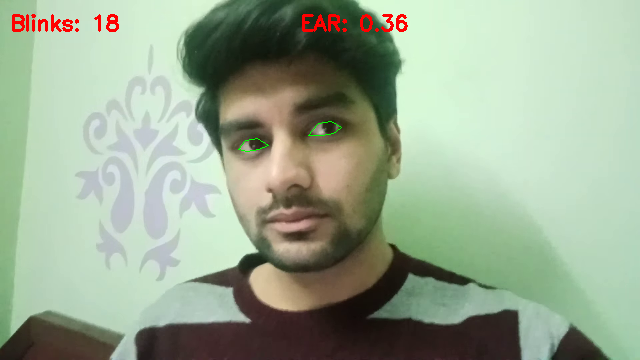

In [19]:
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name

# initialize dlib's face detector (HOG-based) and then create
# the facial landmark predictor
# print("[INFO] loading facial landmark predictor...")
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

frame_array = []

# grab the indexes of the facial landmarks for the left and
# right eye, respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]


cap = cv2.VideoCapture(video)
result = cv2.VideoWriter('output.avi',  
                         cv2.VideoWriter_fourcc(*'MJPG'), 
                         10, (640,360))
# Check if camera opened successfully
if (cap.isOpened() == False):
    print("Error opening video stream or file")

# Read until video is completed
while (cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        frame = cv2.resize(frame, (640, 360))
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        rects = detector(gray, 0)
        # loop over the face detections
        for rect in rects:
            # determine the facial landmarks for the face region, then
            # convert the facial landmark (x, y)-coordinates to a NumPy
            # array
            shape = predictor(gray, rect)
            shape = face_utils.shape_to_np(shape)
            # extract the left and right eye coordinates, then use the
            # coordinates to compute the eye aspect ratio for both eyes
            leftEye = shape[lStart:lEnd]
            rightEye = shape[rStart:rEnd]
            leftEAR = eye_aspect_ratio(leftEye)
            rightEAR = eye_aspect_ratio(rightEye)
            # average the eye aspect ratio together for both eyes
            ear = (leftEAR + rightEAR) / 2.0

            # compute the convex hull for the left and right eye, then
            # visualize each of the eyes
            leftEyeHull = cv2.convexHull(leftEye)
            rightEyeHull = cv2.convexHull(rightEye)
            cv2.drawContours(frame, [leftEyeHull], -1, (0, 255, 0), 1)
            cv2.drawContours(frame, [rightEyeHull], -1, (0, 255, 0), 1)
            # check to see if the eye aspect ratio is below the blink
            # threshold, and if so, increment the blink frame counter
            if ear < EYE_AR_THRESH:
                COUNTER += 1
            # otherwise, the eye aspect ratio is not below the blink
            # threshold
            else:
                # if the eyes were closed for a sufficient number of
                # then increment the total number of blinks
                if COUNTER >= EYE_AR_CONSEC_FRAMES:
                    TOTAL += 1
                # reset the eye frame counter
                COUNTER = 0

            # draw the total number of blinks on the frame along with
            # the computed eye aspect ratio for the frame
            cv2.putText(frame, "Blinks: {}".format(TOTAL), (10, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
            cv2.putText(frame, "EAR: {:.2f}".format(ear), (300, 30),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

        # show the frame
        cv2_imshow(frame)

        result.write(frame)

        key = cv2.waitKey(1) & 0xFF
        clear_output(wait=True)
        frame_array.append(frame)


        # Press Q on keyboard to  exit
        if cv2.waitKey(25) & 0xFF == ord('q'):
            break

    # Break the loop
    else:
        break

# When everything done, release the video capture object
cap.release()
result.release()
# Closes all the frames
cv2.destroyAllWindows()

In [20]:
COUNTER = 0
TOTAL = 0